In [1]:
import pandas as pd
import numpy as np
import uuid
import geopandas as gd
import matplotlib.pyplot as plt

## patient data - code by Gavin Chait, Viares academy 

In [2]:
df = pd.read_csv(r'C:\Users\dg\Desktop\viares\4modul\patient-data-anonymisation-exercise.csv')
df[df["PATIENT_ID"] == "71ba0469-f0cc-4177-ac70-ea07cb01c8b8"]
# Specify columns for removal
suppression = ["SSN", "DRIVERS", "PASSPORT", "FIRST", "LAST", "MAIDEN", "ADDRESS", "ZIP"]
# And drop them
df.drop(suppression, axis=1, inplace=True)


sigma = 0.001 # standard deviation, i.e. the degree of variation from the original data we allow
mu = 1 # the original data, considered the `mean`

np.random.normal(mu, sigma)

0.9990414459345992

In [3]:
from collections import defaultdict

class Pseudonymise:
    
    def __init__(self, sigma=0.001):
        # Initialise a defaultdict, this creates a default dictionary item if it doesn't exist
        # We use this to ensure we maintain data integrity while still randomising
        # http://ikigomu.com/?p=28
        self.sigma = sigma
        self.mu = 0 # we want a deviation from the true point
        # Pseudo-patient dict
        self.pp = defaultdict(lambda: {"uuid":str(uuid.uuid4()),
                                       "lat": np.random.normal(self.mu, self.sigma),
                                       "lon": np.random.normal(self.mu, self.sigma)
                                      })
        
    def create_data(self, identities):
        """
        For each unique identity produce a unique UUID, and a Gaussian randomised `LAT` and `LON`.

        Paramaters
        ----------
        identities: list of strings

        Returns
        -------
        dict
            Each dict entry contains a record containing a "uuid" and modifier for "lat" and "lon"
        """
        for _id in identities:
            self.pp[_id]
        return self.pp
    
    def redact(self, row):
        """
        For a given row in a dataframe, return the pseudonymised version of "PATIENT_ID", "LAT", "LON".
        
        Parameters:
        row: DataFrame row
        
        Returns:
        DataFrame slice of row
        """
        return [
            self.pp[row["PATIENT_ID"]]["uuid"],
            row["LAT"] + self.pp[row["PATIENT_ID"]]["lat"],
            row["LON"] + self.pp[row["PATIENT_ID"]]["lon"],
        ]

p = Pseudonymise()
pp_data = p.create_data(df["PATIENT_ID"])
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
fields = ["PATIENT_ID", "LAT", "LON"]
df[fields] = df[fields].apply(p.redact, axis=1, result_type="expand")

<AxesSubplot:>

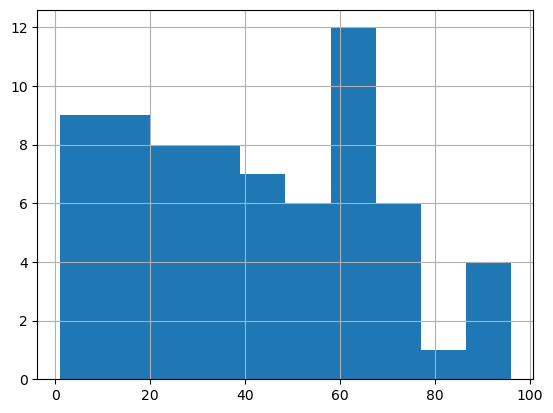

In [4]:
# Create a copy of the source data since aggregations are destructive
dfa = df.copy()
# Convert the date fields to pandas dates
for c in ["START", "STOP", "BIRTHDATE", "DEATHDATE"]:
    dfa[c] = dfa[c].apply(lambda x: pd.to_datetime(x, errors="coerce", dayfirst=True).date())
# Filter for the final medical treatment for all deceased patients
dfa = dfa[dfa.STOP==dfa.DEATHDATE]
dfa.sort_values(by="STOP", inplace=True)
dfa.drop_duplicates(subset="PATIENT_ID", keep="last", inplace=True)
# Create the DEATHAGE 
# This is a VERY approximate age at death calculation
dfa["DEATHAGE"] = dfa.DEATHDATE.apply(lambda x: x.year) - dfa.BIRTHDATE.apply(lambda x: x.year)
# And draw the DEATHAGE distribution, divided into n bins
dfa["DEATHAGE"].hist(bins=10)

## EXERCISE - homework

In [9]:
# Schema and data
source_max = 100
source_range = 10
source_column = 'DEATHAGE'
summary_column = 'TOTAL_CLAIM_COST'
description_column = 'DESCRIPTION'

In [10]:
# function for calculating unique_description, mean_claim_cost and sum_claim_cost for defined DEATHAGE_range
def get_column_summary(df: pd.DataFrame, source_column: str, source_max: int, source_range: int, summary_column: str, description_column: str ) -> pd.DataFrame:
    
    # calculate DEATHAGE_range and save result as new column
    conditions = [df[source_column] <= source_range]
    descriptions = [f'0-{source_range}']
    
    for x in range(source_range, source_max, source_range):
        conditions.append((df[source_column] + 1 > x + 1) & (df[source_column] <= x + source_range))
        descriptions.append(f'{x + 1}-{x + source_range}')
        
    df['DEATHAGE_range'] = ""
    df['DEATHAGE_range'] = np.select(conditions, descriptions)
    df_range = df.set_index('DEATHAGE_range')
    
    # calculate statistics unique descriptions, mean and sum for claim clost
    df_count = df.groupby('DEATHAGE_range', as_index=False)[description_column].nunique().rename(columns={description_column: 'Unique_description'}).set_index('DEATHAGE_range')
    df_mean = df.groupby('DEATHAGE_range', as_index=False)[summary_column].mean().rename(columns={summary_column: 'Mean_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')
    df_total = df.groupby('DEATHAGE_range', as_index=False)[summary_column].sum().rename(columns={summary_column: 'Sum_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')
    
    # join statistics together
    dfs = [df_count,df_mean,df_total,df_range]
    df_join = dfs[0].join(dfs[1:])
    
    # sort df by deathage
    df_final = df_join.sort_values(by=['DEATHAGE'])
    
    return df_final

In [11]:
get_column_summary(dfa, source_column, source_max, source_range, summary_column, description_column)

,Unique_description,Mean_TOTAL_CLAIM_COST,Sum_TOTAL_CLAIM_COST,PATIENT_ID,START,STOP,ENCOUNTERCLASS,DESCRIPTION,TOTAL_CLAIM_COST,PAYER_COVERAGE,...,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,LAT,LON,DEATHAGE
DEATHAGE_range,,,,,,,,,,,,,,,,,,,,,
0-10,2,129.16,1162.44,08dd4d41-aef9-47a8-b863-b7e3c09466e9,2019-05-15,2019-05-15,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Sturbridge Massachusetts US,Salem,Massachusetts,Essex County,42.519426,-70.908607,1
0-10,2,129.16,1162.44,170360aa-fe96-4306-8ad2-d14af7083c8b,2005-08-19,2005-08-19,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Milford Massachusetts US,Quincy,Massachusetts,Norfolk County,42.241185,-71.057952,1
0-10,2,129.16,1162.44,dd60e8ed-0b87-4ade-b352-6b39392f45c8,1976-11-11,1976-11-11,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Harwich Massachusetts US,Leicester,Massachusetts,Worcester County,42.202541,-71.873593,1
0-10,2,129.16,1162.44,ca7ee3f7-57dd-4ea6-a991-82042d5fe6aa,1983-11-07,1983-11-07,wellness,Death Certification,129.16,0.00,...,white,hispanic,F,Lima Lima Province PE,Waltham,Massachusetts,Middlesex County,42.321388,-71.188195,1
0-10,2,129.16,1162.44,15f33a66-c0e8-4e71-938b-c85ddb324843,2010-01-10,2010-01-10,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Boston Massachusetts US,Lynn,Massachusetts,Essex County,42.432524,-70.975602,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71-80,3,129.16,645.80,9f6d7266-c148-41f8-888c-4eda53864f7b,1991-06-02,1991-06-02,emergency,Stroke,129.16,89.16,...,white,nonhispanic,M,Maynard Massachusetts US,Worcester,Massachusetts,Worcester County,42.242109,-71.819037,77
81-90,1,129.16,129.16,18071831-0fe5-4465-989b-7eb931a85dc4,2013-03-12,2013-03-12,emergency,Stroke,129.16,89.16,...,white,nonhispanic,F,Boston Massachusetts US,West Springfield,Massachusetts,Hampden County,42.151832,-72.661719,90
91-100,3,129.16,387.48,03667d89-0532-4bfc-9bbb-2b3cc25615d6,2013-08-20,2013-08-20,emergency,Stroke,129.16,89.16,...,asian,hispanic,F,Lima Lima Province PE,Cambridge,Massachusetts,Middlesex County,42.418311,-71.127903,91
